In [ ]:
# from analysis_utils import *
import importlib
import analysis_utils
importlib.reload(analysis_utils)
from analysis_utils import *

In [ ]:
# Paths to csv's holding response values and sentence lengths
# dim0 represents the LM separator, dim1 represents the author
wiki_paths = [
                [ 
                  "Responses/wiki_Llama3.1_clean_none_Meta-Llama-3.1-8B-Instruct.csv",
                  "Responses/wiki_Falcon_clean_none_Meta-Llama-3.1-8B-Instruct.csv",
                  "Responses/wiki_human_text_none_Meta-Llama-3.1-8B-Instruct.csv",
                  "Responses/wiki_gpt_clean_none_Meta-Llama-3.1-8B-Instruct.csv",
                  "Responses/wiki_R1_clean_none_Meta-Llama-3.1-8B-Instruct.csv"
                ],
                [ 
                  "Responses/wiki_Llama3.1_clean_none_falcon-7b.csv",
                  "Responses/wiki_Falcon_clean_none_falcon-7b.csv",
                  "Responses/wiki_human_text_none_falcon-7b.csv",
                  "Responses/wiki_gpt_clean_none_falcon-7b.csv",
                  "Responses/wiki_R1_clean_none_falcon-7b.csv"
                ],
                [ 
                  "Responses/wiki_Llama3.1_clean_none_phi-2.csv",
                  "Responses/wiki_Falcon_clean_none_phi-2.csv",
                  "Responses/wiki_human_text_none_phi-2.csv",
                  "Responses/wiki_gpt_clean_none_phi-2.csv",
                  "Responses/wiki_R1_clean_none_phi-2.csv"
                ],
                [ 
                  "Responses/wiki_Llama3.1_clean_none_DeepSeek-R1-Distill-Qwen-7B.csv",
                  "Responses/wiki_Falcon_clean_none_DeepSeek-R1-Distill-Qwen-7B.csv",
                  "Responses/wiki_human_text_none_DeepSeek-R1-Distill-Qwen-7B.csv",
                  "Responses/wiki_gpt_clean_none_DeepSeek-R1-Distill-Qwen-7B.csv",
                  "Responses/wiki_R1_clean_none_DeepSeek-R1-Distill-Qwen-7B.csv"
                ]
]

news_paths = [
                [
                "Responses/news_Llama3.1_clean_none_Meta-Llama-3.1-8B-Instruct.csv",
                "Responses/news_Falcon_clean_none_Meta-Llama-3.1-8B-Instruct.csv",
                "Responses/news_human_text_none_Meta-Llama-3.1-8B-Instruct.csv",
                "Responses/news_gpt_clean_none_Meta-Llama-3.1-8B-Instruct.csv",
                "Responses/news_R1_clean_none_Meta-Llama-3.1-8B-Instruct.csv"
                ],
                [
                "Responses/news_Llama3.1_clean_none_falcon-7b.csv",
                "Responses/news_Falcon_clean_none_falcon-7b.csv",
                "Responses/news_human_text_none_falcon-7b.csv",
                "Responses/news_gpt_clean_none_falcon-7b.csv",
                "Responses/news_R1_clean_none_falcon-7b.csv"
                ],
                [
                "Responses/news_Llama3.1_clean_none_phi-2.csv",
                "Responses/news_Falcon_clean_none_phi-2.csv",
                "Responses/news_human_text_none_phi-2.csv",
                "Responses/news_gpt_clean_none_phi-2.csv",
                "Responses/news_R1_clean_none_phi-2.csv"
                ],
                [
                "Responses/news_Llama3.1_clean_none_DeepSeek-R1-Distill-Qwen-7B.csv",
                "Responses/news_Falcon_clean_none_DeepSeek-R1-Distill-Qwen-7B.csv",
                "Responses/news_human_text_none_DeepSeek-R1-Distill-Qwen-7B.csv",
                "Responses/news_gpt_clean_none_DeepSeek-R1-Distill-Qwen-7B.csv",
                "Responses/news_R1_clean_none_DeepSeek-R1-Distill-Qwen-7B.csv"
                ]
]

abstracts_paths = [
                [
                "Responses/abstracts_Llama3.1_clean_none_Meta-Llama-3.1-8B-Instruct.csv",
                "Responses/abstracts_Falcon_clean_none_Meta-Llama-3.1-8B-Instruct.csv",
                "Responses/abstracts_human_text_none_Meta-Llama-3.1-8B-Instruct.csv",
                "Responses/abstracts_gpt_clean_none_Meta-Llama-3.1-8B-Instruct.csv",
                "Responses/abstracts_R1_clean_none_Meta-Llama-3.1-8B-Instruct.csv"
                ],
                [
                "Responses/abstracts_Llama3.1_clean_none_falcon-7b.csv",
                "Responses/abstracts_Falcon_clean_none_falcon-7b.csv",
                "Responses/abstracts_human_text_none_falcon-7b.csv",
                "Responses/abstracts_gpt_clean_none_falcon-7b.csv",
                "Responses/abstracts_R1_clean_none_falcon-7b.csv"
                ],
                [
                "Responses/abstracts_Llama3.1_clean_none_phi-2.csv",
                "Responses/abstracts_Falcon_clean_none_phi-2.csv",
                "Responses/abstracts_human_text_none_phi-2.csv",
                "Responses/abstracts_gpt_clean_none_phi-2.csv",
                "Responses/abstracts_R1_clean_none_phi-2.csv"
                ],
                [
                "Responses/abstracts_Llama3.1_clean_none_DeepSeek-R1-Distill-Qwen-7B.csv",
                "Responses/abstracts_Falcon_clean_none_DeepSeek-R1-Distill-Qwen-7B.csv",
                "Responses/abstracts_human_text_none_DeepSeek-R1-Distill-Qwen-7B.csv",
                "Responses/abstracts_gpt_clean_none_DeepSeek-R1-Distill-Qwen-7B.csv",
                "Responses/abstracts_R1_clean_none_DeepSeek-R1-Distill-Qwen-7B.csv"
                ]
]


=== Wiki Domain ===

Main Results Table (Aggregate excludes phi-2):
| LM Separator                |   AUC (∈authors) |   AUC (∉authors) |   JS (∈authors) |   JS (∉authors) |   OE (∈authors) |   OE (∉authors) |   #Pairs (∈authors) |   #Pairs (∉authors) |
|:----------------------------|-----------------:|-----------------:|----------------:|----------------:|----------------:|----------------:|--------------------:|--------------------:|
| Meta llama 3.1 8b instruct  |            0.755 |            0.632 |           0.122 |           0.050 |           0.508 |           0.247 |                   4 |                   6 |
| Falcon 7b                   |            0.671 |            0.639 |           0.074 |           0.049 |           0.362 |           0.205 |                   4 |                   6 |
| Deepseek r1 distill qwen 7b |            0.712 |            0.653 |           0.091 |           0.054 |           0.457 |           0.220 |                   4 |                   6 |
|

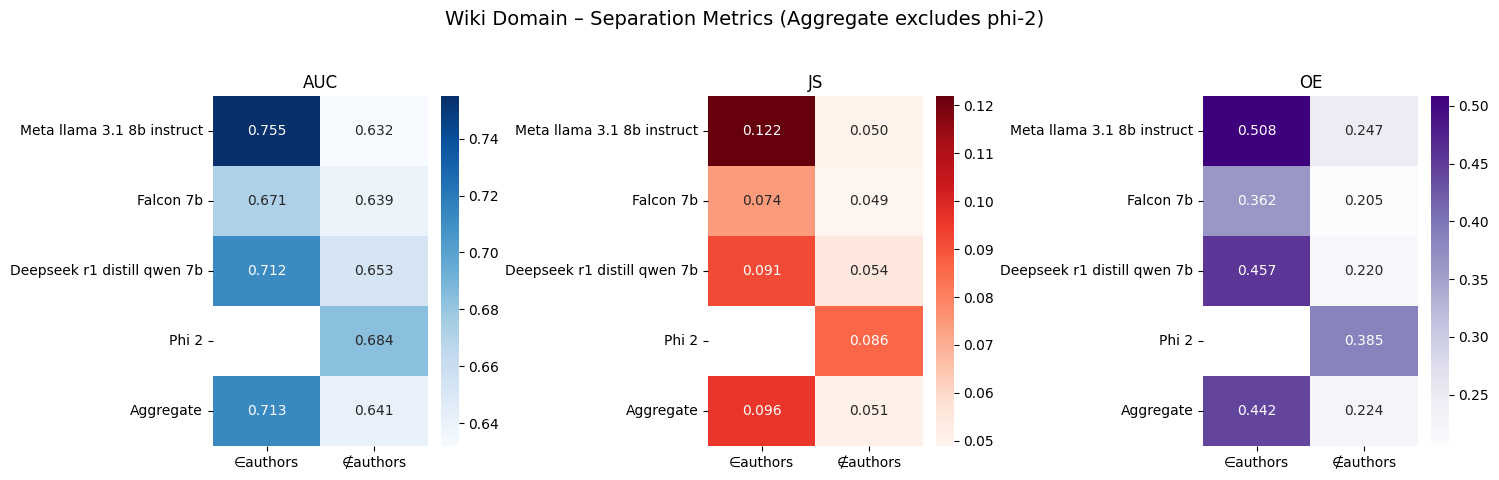


=== News Domain ===

Main Results Table (Aggregate excludes phi-2):
| LM Separator                |   AUC (∈authors) |   AUC (∉authors) |   JS (∈authors) |   JS (∉authors) |   OE (∈authors) |   OE (∉authors) |   #Pairs (∈authors) |   #Pairs (∉authors) |
|:----------------------------|-----------------:|-----------------:|----------------:|----------------:|----------------:|----------------:|--------------------:|--------------------:|
| Meta llama 3.1 8b instruct  |            0.736 |            0.655 |           0.119 |           0.092 |           0.612 |           0.704 |                   4 |                   6 |
| Falcon 7b                   |            0.584 |            0.687 |           0.072 |           0.075 |           0.350 |           0.348 |                   4 |                   6 |
| Deepseek r1 distill qwen 7b |            0.643 |            0.692 |           0.073 |           0.103 |           0.311 |           0.605 |                   4 |                   6 |
|

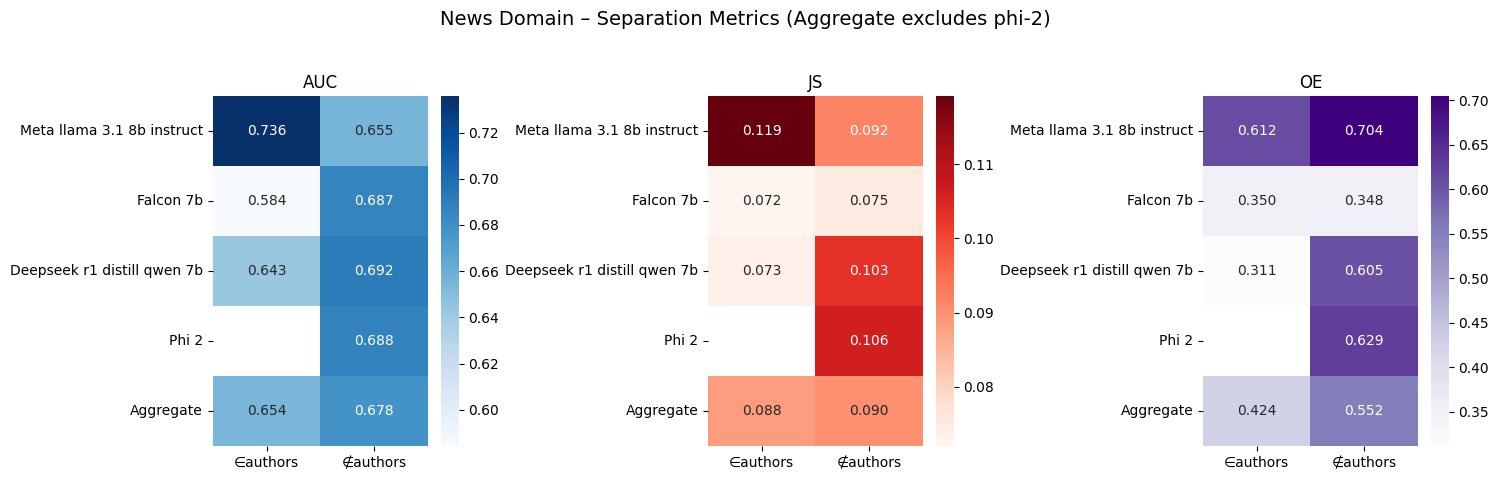


=== Abstracts Domain ===

Main Results Table (Aggregate excludes phi-2):
| LM Separator                |   AUC (∈authors) |   AUC (∉authors) |   JS (∈authors) |   JS (∉authors) |   OE (∈authors) |   OE (∉authors) |   #Pairs (∈authors) |   #Pairs (∉authors) |
|:----------------------------|-----------------:|-----------------:|----------------:|----------------:|----------------:|----------------:|--------------------:|--------------------:|
| Meta llama 3.1 8b instruct  |            0.650 |            0.620 |           0.053 |           0.054 |           0.236 |           0.339 |                   4 |                   6 |
| Falcon 7b                   |            0.628 |            0.632 |           0.061 |           0.045 |           0.328 |           0.208 |                   4 |                   6 |
| Deepseek r1 distill qwen 7b |            0.655 |            0.598 |           0.054 |           0.043 |           0.240 |           0.231 |                   4 |                   

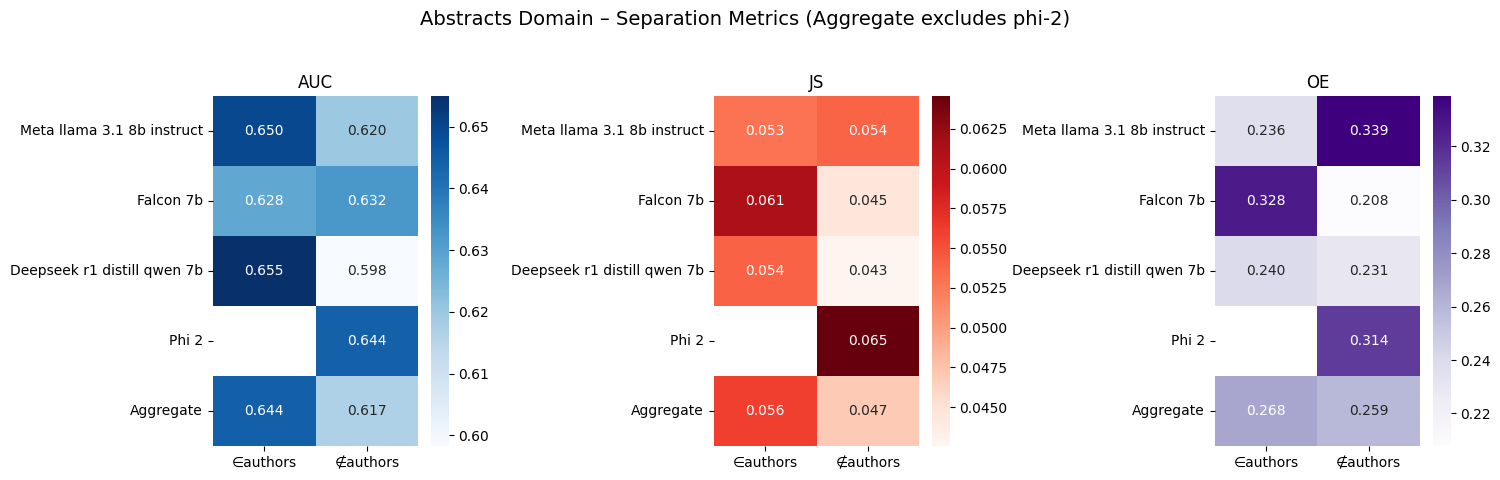

In [33]:
# 1. self vs non‑self
df_wiki= run_lm_comparison_heatmap(wiki_paths)
df_news = run_lm_comparison_heatmap(news_paths)
df_abstracts = run_lm_comparison_heatmap(abstracts_paths)

In [36]:
domain_dfs = [df_wiki, df_news, df_abstracts]          
df_main = pd.concat(domain_dfs, ignore_index=True)

rows = df_main[(df_main["LM Separator"] != "Aggregate") &
               (~df_main["JS (∈authors)"].isna())]      # drop phi‑2 in‑author NaNs
total = len(rows)

# -----------------------------------------------------------
#  Wins & relative deltas for each metric
def metric_summary(metric):
    col_in  = f"{metric} (∈authors)"
    col_out = f"{metric} (∉authors)"
    win_pct = 100 * (rows[col_in] > rows[col_out]).sum() / total
    abs_med = (rows[col_in] - rows[col_out]).median()
    rel_med = ( (rows[col_in] - rows[col_out]) / rows[col_out] ).median() * 100
    return win_pct.round(1), abs_med.round(3), rel_med.round(1)

X_JS,  ΔJS_abs, ΔJS_rel = metric_summary("JS")
X_OE,  ΔOE_abs, ΔOE_rel = metric_summary("OE")
X_AUC, ΔAUC_abs, _      = metric_summary("AUC")  

# -----------------------------------------------------------
#  Sentence‑length saving from OE ratio
LEN_SAVE = (1 - (rows["OE (∉authors)"] / rows["OE (∈authors)"]).median()) * 100
LEN_SAVE = LEN_SAVE.round(1)

# -----------------------------------------------------------
#  Jeffreys‑proxy consistency
J_smaller = rows["JS (∈authors)"] < rows["JS (∉authors)"]
Δ_positive = rows["OE (∈authors)"] > rows["OE (∉authors)"]
Z = 100 * (J_smaller & Δ_positive).sum() / total
Z = Z.round(1)

print(f"Win %  JS: {X_JS}   OE: {X_OE}   AUC: {X_AUC}")
print(f"Median Δ  JS: {ΔJS_abs}  ({ΔJS_rel}%)   OE: {ΔOE_abs} ({ΔOE_rel}%)")
print(f"Sentence length saved ≈ {LEN_SAVE}%")
print(f"J↓ → Δ↑ holds in {Z}% of rows")


Win %  JS: 66.7   OE: 66.7   AUC: 66.7
Median Δ  JS: 0.017  (29.9%)   OE: 0.009 (3.9%)
Sentence length saved ≈ 3.8%
J↓ → Δ↑ holds in 11.1% of rows


In [ ]:
# use auc/js/optimal_error
print(f"Wikipedia dataset")
compare_author_vs_others(wiki_paths, metric='auc')
print(f"News dataset")
compare_author_vs_others(news_paths, metric='auc')
print(f"Abstracts dataset")
compare_author_vs_others(abstracts_paths, metric='auc')

In [ ]:
# use auc/js/optimal_error
print(f"Wikipedia dataset")
compare_author_vs_others(wiki_paths, metric='optimal_error')
print(f"News dataset")
compare_author_vs_others(news_paths, metric='optimal_error')
print(f"Abstracts dataset")
compare_author_vs_others(abstracts_paths, metric='optimal_error')

In [ ]:
print(f"Wikipedia dataset")
compare_author_vs_others(wiki_paths, metric='js')
print(f"News dataset")
compare_author_vs_others(news_paths, metric='js')
print(f"Abstracts dataset")
compare_author_vs_others(abstracts_paths, metric='js')

In [ ]:
run_lm_comparison_save_img(wiki_paths, save_prefix='wiki')
run_lm_comparison_save_img(news_paths,  save_prefix='news')
run_lm_comparison_save_img(abstracts_paths, save_prefix='abstracts')

In [ ]:
run_lm_comparison(wiki_paths)
run_lm_comparison(news_paths)
run_lm_comparison(abstracts_paths)

In [ ]:
# Use AUC as metric
print(f"Wikipedia dataset")
compare_human_to_llm(wiki_paths)
print(f"News dataset")
compare_human_to_llm(news_paths)
print(f"Abstracts dataset")
compare_human_to_llm(abstracts_paths)

In [ ]:
# Use Optimal error exponent as metric
print(f"Wikipedia dataset")
compare_human_to_llm_oe(wiki_paths)
print(f"News dataset")
compare_human_to_llm_oe(news_paths)
print(f"Abstracts dataset")
compare_human_to_llm_oe(abstracts_paths)

In [ ]:
# Use JS distance as metric
print(f"Wikipedia dataset")
compare_human_to_llm_js(wiki_paths)
print(f"News dataset")
compare_human_to_llm_js(news_paths)
print(f"Abstracts dataset")
compare_human_to_llm_js(abstracts_paths)

In [ ]:
# Apply bootsrapping on responses for confidence interval
compare_human_to_llm_ci(wiki_paths)
compare_human_to_llm_ci(news_paths)
compare_human_to_llm_ci(abstracts_paths)


In [ ]:
def filter_out_phi2(paths):
    """
    Removes paths containing 'phi-2' in their filenames.
    """
    filtered_paths = []
    for group in paths:
        if not any('phi-2' in path.lower() for path in group):
            filtered_paths.append(group)
    return filtered_paths

wiki_paths_no_phi2 = filter_out_phi2(wiki_paths)
news_paths_no_phi2 = filter_out_phi2(news_paths)
abstracts_paths_no_phi2 = filter_out_phi2(abstracts_paths)

# run_lm_comparison(wiki_paths_no_phi2)
# run_lm_comparison(news_paths_no_phi2)
# run_lm_comparison(abstracts_paths_no_phi2)

run_lm_comparison(wiki_paths)
run_lm_comparison(news_paths)
run_lm_comparison(abstracts_paths)

In [ ]:
# # optional code for viewing each auc value computed

# print("=== Wiki Dataset ===")
# group1_aucs, group1_diffs, group2_aucs, group2_diffs = [],[],[],[]
# for i, lm_paths in enumerate(wiki_paths):
#     lm_is_author_aucs, lm_is_author_diffs, lm_not_author_aucs, lm_not_author_diffs = lm_aggregate_metrics(lm_paths)
#     group1_aucs.extend(lm_is_author_aucs)
#     group1_diffs.extend(lm_is_author_diffs)
#     group2_aucs.extend(lm_not_author_aucs)
#     group2_diffs.extend(lm_not_author_diffs)
#     _, _, lm_name, _ = extract_info_from_path(lm_paths[0])

#     print(f"\nResults for {lm_name} separator:")
#     print(f"LM-In-Authors:")
#     print(f"    AUCs: {lm_is_author_aucs}")
#     print(f"    Diffs: {lm_is_author_diffs}")
#     print(f"LM-Not-In-Authors:")
#     print(f"    AUCs: {lm_not_author_aucs}")
#     print(f"    Diffs: {lm_not_author_diffs}")

In [ ]:
compare_hist('Responses/wiki_human_text_none_phi-2.csv', 
             'Responses/wiki_gpt_clean_none_phi-2.csv', 
             'Responses/wiki_human_text_none_phi-2.csv', 
             'Responses/wiki_gpt_clean_none_phi-2.csv')

In [ ]:
compare_hist('Responses/wiki_human_text_none_phi-2.csv', 
             'Responses/wiki_Falcon_clean_none_phi-2.csv', 
             'Responses/wiki_human_text_none_phi-2.csv', 
             'Responses/wiki_Falcon_clean_none_phi-2.csv')

In [ ]:
compare_hist('Responses/wiki_Llama3.1_clean_none_Meta-Llama-3.1-8B-Instruct.csv', 
             'Responses/wiki_human_text_none_Meta-Llama-3.1-8B-Instruct.csv', 
             'Responses/wiki_Llama3.1_clean_none_phi-2.csv', 
             'Responses/wiki_human_text_none_phi-2.csv')

In [ ]:
compare_hist('Responses/abstracts_Llama3.1_clean_none_Meta-Llama-3.1-8B-Instruct.csv', 
             'Responses/abstracts_Falcon_clean_none_Meta-Llama-3.1-8B-Instruct.csv', 
             'Responses/abstracts_Llama3.1_clean_none_phi-2.csv', 
             'Responses/abstracts_Falcon_clean_none_phi-2.csv')

In [ ]:
compare_hist('Responses/abstracts_R1_clean_none_DeepSeek-R1-Distill-Qwen-7B.csv', 
             'Responses/abstracts_human_text_none_DeepSeek-R1-Distill-Qwen-7B.csv', 
             'Responses/abstracts_R1_clean_none_phi-2.csv', 
             'Responses/abstracts_human_text_none_phi-2.csv')

In [ ]:
compare_hist_oe('Responses/abstracts_R1_clean_none_DeepSeek-R1-Distill-Qwen-7B.csv', 
             'Responses/abstracts_human_text_none_DeepSeek-R1-Distill-Qwen-7B.csv', 
             'Responses/abstracts_R1_clean_none_phi-2.csv', 
             'Responses/abstracts_human_text_none_phi-2.csv')

In [ ]:
compare_hist_oe('Responses/news_Falcon_clean_none_Meta-Llama-3.1-8B-Instruct.csv', 
             'Responses/news_human_text_none_Meta-Llama-3.1-8B-Instruct.csv', 
             'Responses/news_Falcon_clean_none_phi-2.csv', 
             'Responses/news_human_text_none_phi-2.csv')

In [ ]:
compare_separators(news_paths, "Human", "Falcon")

In [ ]:
compare_separators(abstracts_paths, "Human", "Falcon")

In [ ]:
compare_separators_with_kl(wiki_paths, "Human", "Falcon")
compare_separators_with_kl(news_paths, "Human", "Falcon")
compare_separators_with_kl(abstracts_paths, "Human", "Falcon")

In [ ]:
compare_separators_with_kl(abstracts_paths, "Human", "R1")

In [ ]:
compare_separators_with_kl(wiki_paths, "Human", "R1")

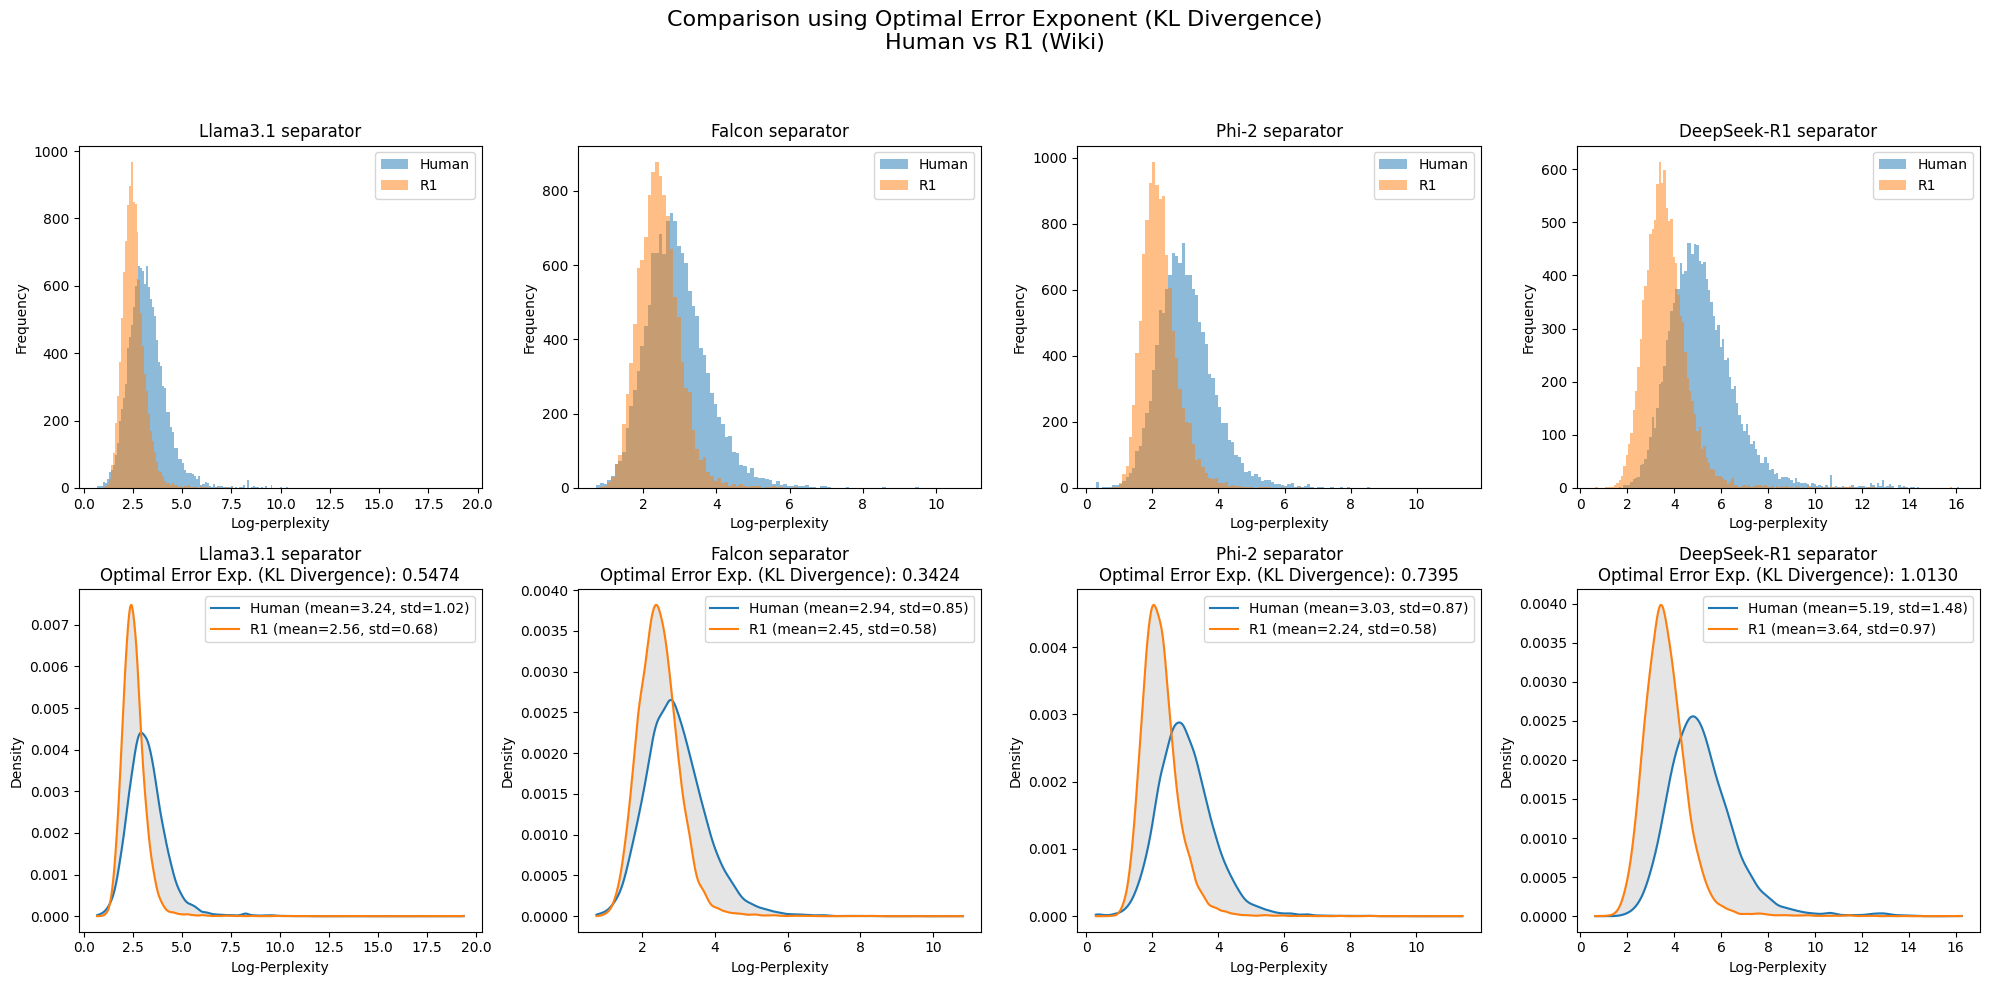

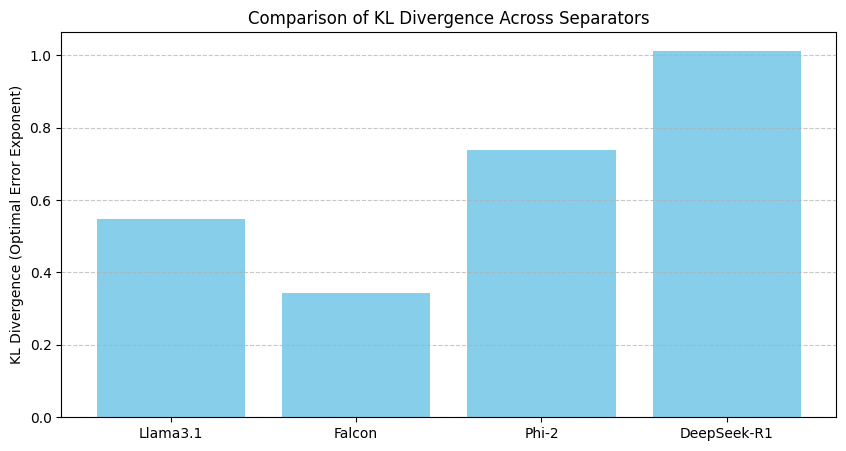

In [40]:
compare_separators_with_kl(wiki_paths, "Human", "R1")


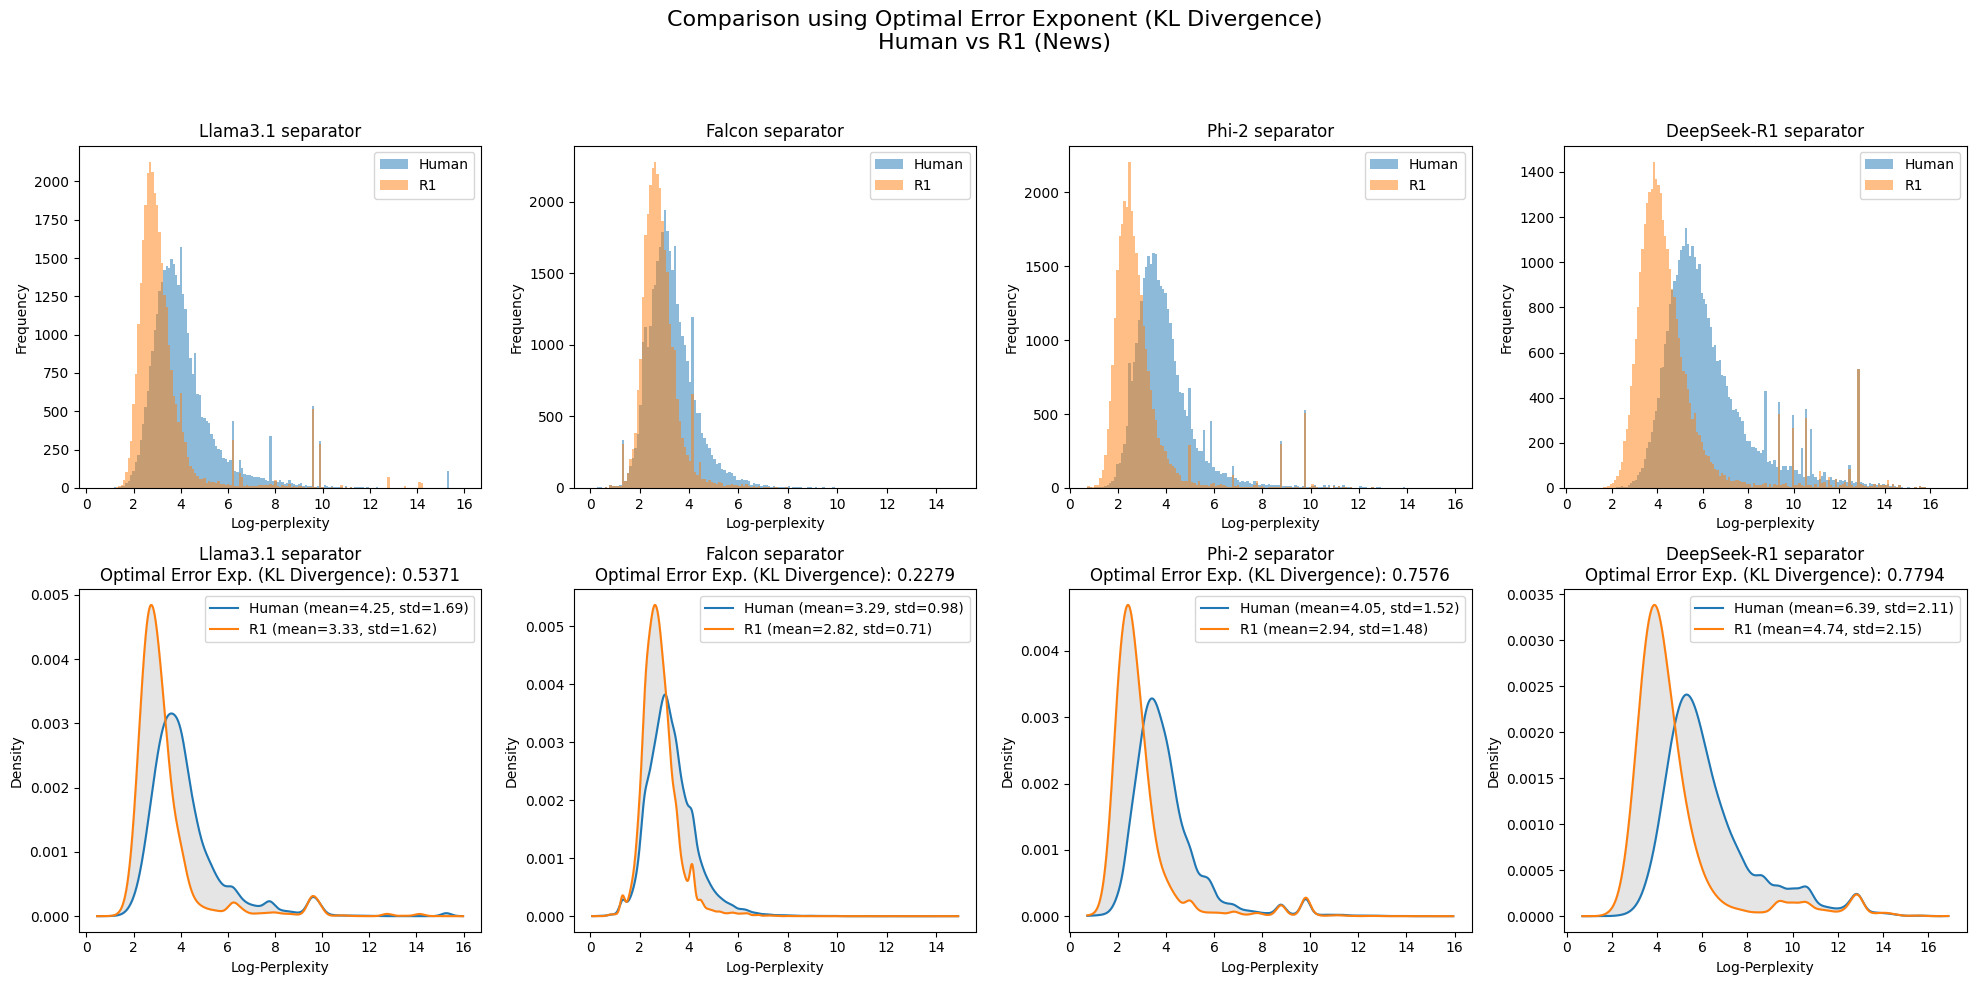

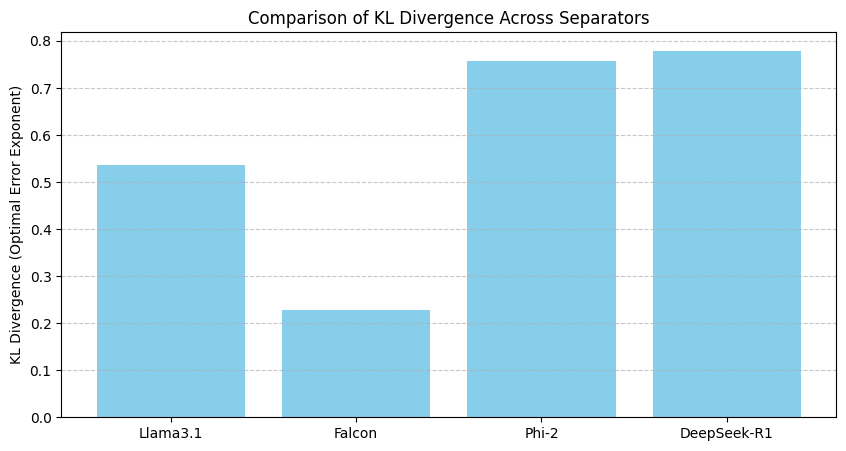

In [38]:
compare_separators_with_kl(news_paths, "Human", "R1")

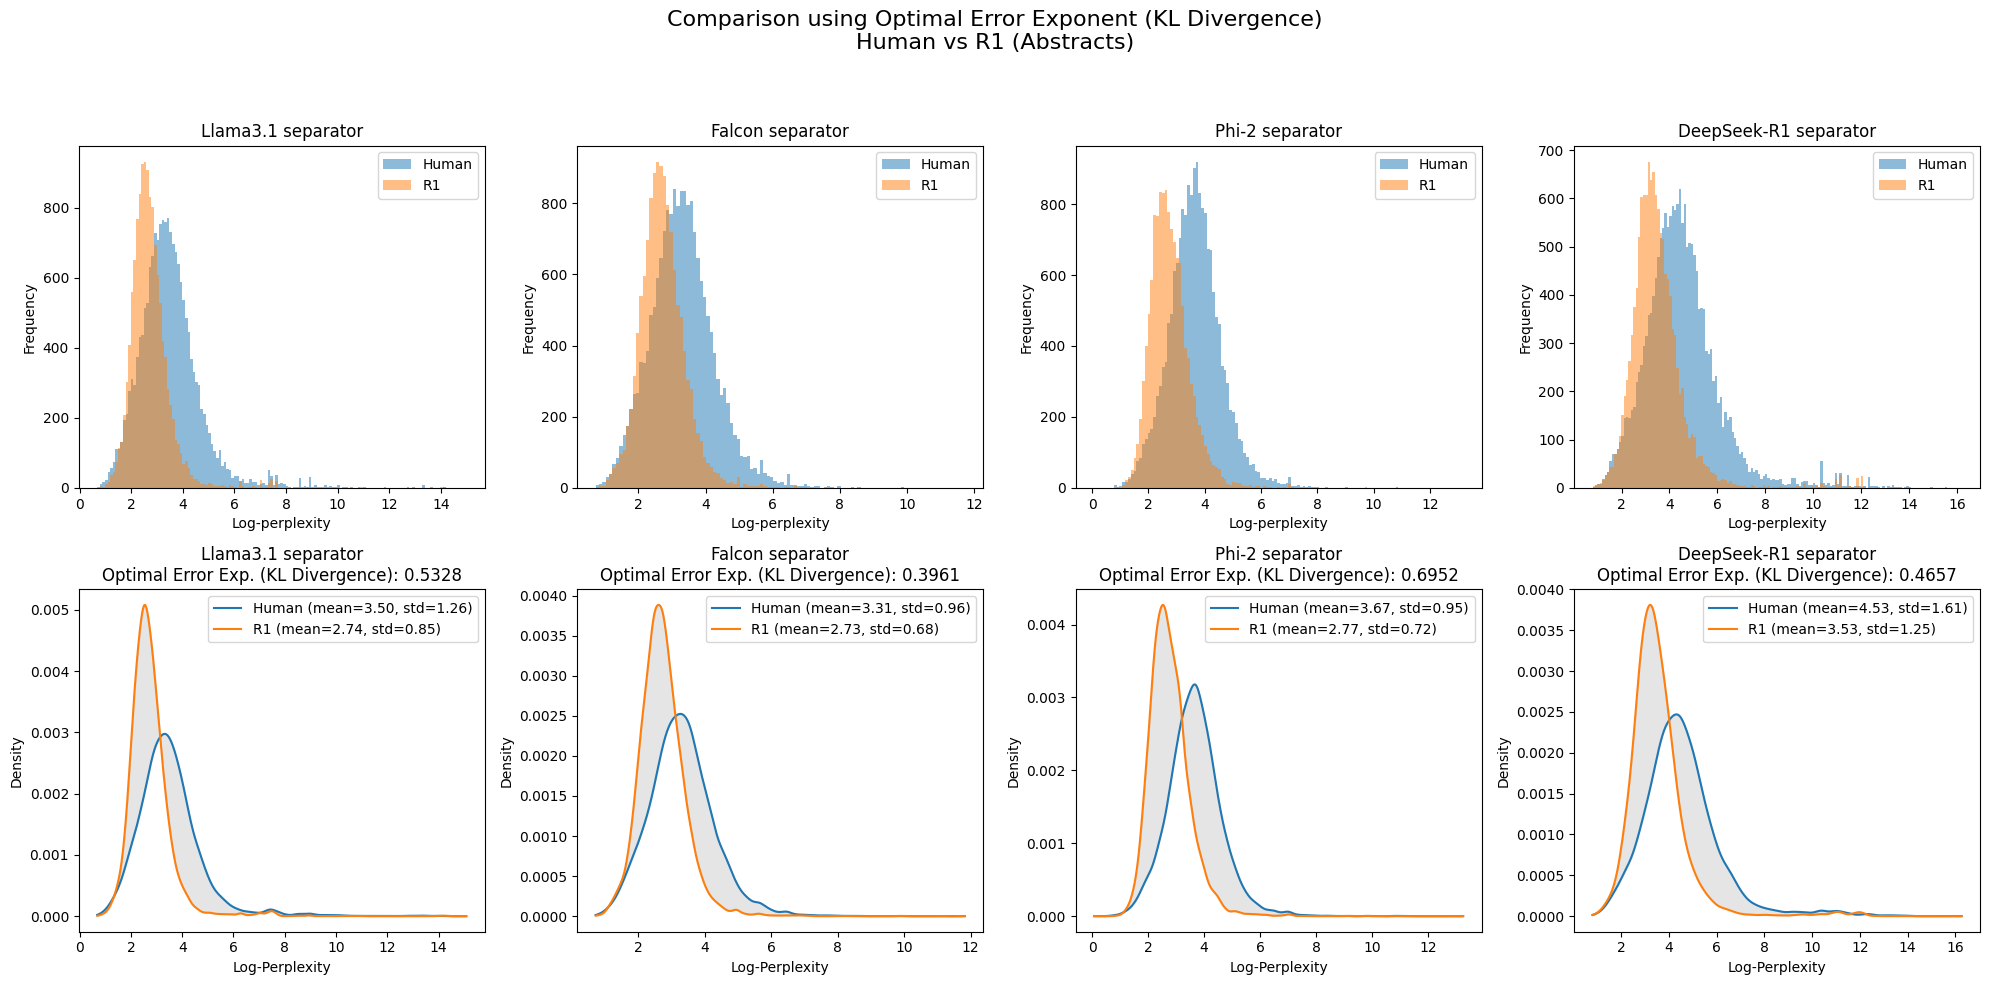

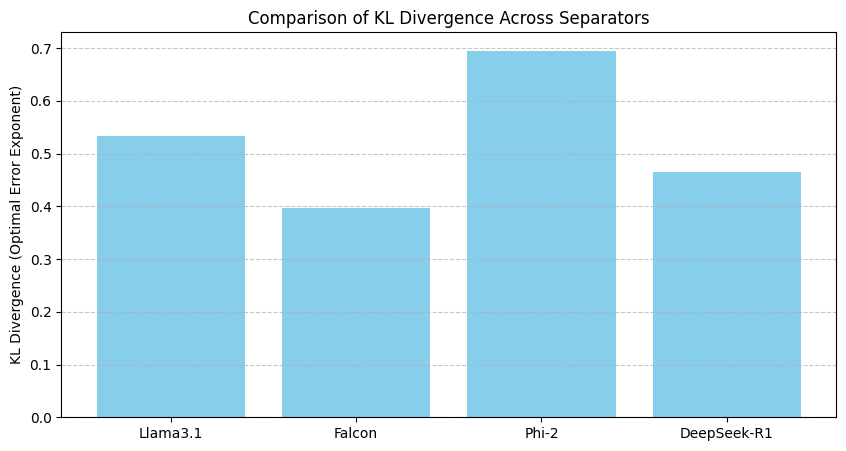

In [39]:
compare_separators_with_kl(abstracts_paths, "Human", "R1")